# Preparation

## Importing packages

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
from math import sqrt
from itertools import cycle
from statsmodels.stats import power
from palettable.cartocolors.qualitative import Prism_8
from palettable.cartocolors.qualitative import Prism_4
from palettable.cartocolors import qualitative
from scipy import interpolate
from statsmodels.stats.power import TTestIndPower
import dabest

## Define helper functions

In [2]:
def metacont(df):
    '''Creating summary table that includes summary effect size and heterogeneity metrics
    The input is a DataFrame generated from summary_stats.csv'''
    out = pd.DataFrame()
    for prop in df['prop'].unique():
        data = df.loc[df['prop']==prop]
        if len(data) < 2:
            pass
        else:
            W = 1/data['var']
            Q = sum(W*data['g']**2) - sum(W*data['g'])**2/sum(W)
            C = sum(W) - sum(W**2)/(sum(W))
            Tsquared = (Q - (len(data)-1))/C
            Isquared = (Q - (len(data)-1))/Q
            if Tsquared < 0:
                Tsquared = 0
                Isquared = 0
            Wstar = 1/(data['var']+Tsquared)
            var = 1/sum(Wstar)
            Mstar = sum(Wstar*data['g'])/sum(Wstar)
            lo = Mstar - 1.96*sqrt(var)
            hi = Mstar + 1.96*sqrt(var)
            Z = Mstar/np.sqrt(var)
            power = (1-norm.pdf(1.96-abs(Z))) + norm.pdf(-1.96-abs(Z))
            row = pd.DataFrame(np.array([[int(len(data)), Q, Mstar, lo, hi, var, Tsquared, Isquared, Z, power]]),
                               index = [prop], 
                               columns = ['k', 'Q', 'weighted mean', 'lo', 'hi', 'variance', 'tau^2', 'I^2', 'Z', 'power'])
            out = out.append(row)
    return out

In [3]:
# abbrev. labels
prop_labels = {
    'Gin': '$G_{in}$',
    'Rin': '$R_{in}$',
    'RMP': 'RMP',
    'Vth': '$V_{th}$',
    'f-I gain': 'f-I gain',
    'AP amp': '$AP_{amp}$',
    'AP dur': '$AP_{dur}$',
    'AHP amp': '$AHP_{amp}$',
    'AHP dur': '$AHP_{dur}$',
    'capacitance': '$C_m$',
    'rheobase': 'Rheobase'
}

In [4]:
def copy_table (df):
    '''Converting the summary effect size table to appropriate format for display'''
    df.index = df.index.map(prop_labels)
    df['Confidence Interval'] = ['['+str("{0:.2g}".format(lo))+', '+str("{0:.2g}".format(hi))+']' for lo, hi in zip(df['lo'].values, df['hi'].values)]    
    df = df.rename(columns={'weighted mean': 'Summary effect size'})
    df = df[['k', 'Q','Summary effect size', 'Confidence Interval', 'tau^2', 'I^2']]
    return df

In [5]:
def draw_es(effects, prop):
    '''Drawing forest plot for a single electrophysiological property'''
    effects = effects.pivot_table(index=['prop', 'key'], values=['g', 'hi', 'lo'], dropna=False)
    fig, ax = plt.subplots()
    ax.set_xlim(-2,2)
    x = effects.loc[prop]['g']
    y = effects.loc[prop]['g'].index
    ax.plot(x,y, 'o', markersize=3)
    ax.set_title(labels[prop])
    x_low = effects.loc[prop]['lo'].values
    x_high = effects.loc[prop]['hi'].values
    ax.hlines(y, x_low, x_high, lw=2)
    ax.hlines(y,*ax.get_xlim(), lw=0.5, color='grey', zorder=-1)
    ax.axvline(0,ls='--',c='k', lw=1)
    sns.despine(left=True, right=True, top=True, bottom=False)
    for tick in ax.get_yticklines():
        tick.set_visible(False)
    ymin,ymax = ax.get_ylim()
    ax.set_ylim(ymin-1, ymax+1)
    ax.invert_yaxis()
    #ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

## Data wrangling

Import summary statistics for studies without raw data

In [6]:
data = pd.read_csv('./summary_stats.csv')

Calculating estimates of Hedges' g from studies where only summary statistics are available

In [7]:
#Calculating pooled standard deviations
data['s_pooled'] = np.sqrt(((data['Nc']-1)*data['Sc']**2 + (data['Ne']-2)*data['Se']**2)/ 
                           (data['Nc']+data['Ne']-2))

#Calculating point estimates of Hedges' g
data['g'] = (1 - 3/(4*(data['Nc']+data['Ne']-2)-9))*(data['Me']-data['Mc'])/data['s_pooled']

#Calculating confidence intervals of Hedges'g
data['var'] = (data['Nc']+data['Ne'])/(data['Nc']*data['Ne']) + data['g']**2/(2*(data['Ne']+data['Nc']-3.94))
data['lo'] = data['g']-1.96*np.sqrt(data['var'])
data['hi'] = data['g']+1.96*np.sqrt(data['var'])

Loading raw data from primary studies if they are available, standardising property names 

In [8]:
delestree = pd.read_csv('./raw_data/Delestree2014.csv')
delestree = delestree.rename(columns = {
    'Vm (mV)':'RMP', 
    'GinPeak':'Gin', 
    'Ion (nA)':'rheobase', 
    'asc slope (Hz/nA)':'f-I gain', 
    'Vth (mV)':'Vth',
    'Mouse genotype':'genotype'
})
delestree['genotype'] = delestree['genotype'].map({'-/-':'WT', 
                           'G1H/-':'SOD'})
delestree['key'] = 'Delestree2014'
delestree['age'] = 'P40–50'
delestree['age_group'] = 'P30–60'
delestree['type'] = 'postnatal'

In [9]:
leroy = pd.read_csv('./raw_data/Leroy2014.csv')
leroy = leroy.rename(columns = {'SOD1':'genotype'})
leroy['genotype'] = leroy['genotype'].map({'+/+':'WT', '+/-':'SOD'})
leroy['key'] = 'Leroy2014'
leroy['age'] = 'P6–10'
leroy['age_group'] = 'P6–12'
leroy['type'] = 'postnatal'

In [10]:
huh = pd.read_csv('./raw_data/Huh2020.csv')
huh = huh.rename(columns={
    'Genotype': 'genotype',
    'Ion': 'rheobase',
    'Gain_Asc': 'f-I gain',
})
huh['genotype'] = huh['genotype'].map({'WT':'WT','SOD1':'SOD'})

huh_30 = huh.loc[huh['AgeGroup']=='P30–60'].copy()
huh_30['age'] = 'P30–60'
huh_30['age_group'] = 'P30–60'
huh_30['key'] = 'Huh_P30–60'

huh_60 = huh.loc[huh['AgeGroup']=='P60–90'].copy()
huh_60['age'] = 'P60–90'
huh_60['age_group'] = 'P90–120'
huh_60['key'] = 'Huh_P60–90'


huh_90 = huh.loc[huh['AgeGroup']=='P90–120'].copy()
huh_90['age'] = 'P90–120'
huh_90['age_group'] = 'P90–120'
huh_90['key'] = 'Huh_P90–120'


for df in [huh_30, huh_60, huh_90]:
    df['type'] = 'in vivo'

In [11]:
jensen = pd.read_excel('./raw_data/Jensen2020.xlsx')
jensen = jensen.rename(columns = {
    'type':'genotype',
    'vm': 'RMP',
    'Rheobase':'rheobase',
    'Prim slope':'f-I gain',
    'resistance':'Rin',
    'conductance':'Gin'
})
jensen['type'] = 'in vivo'
jensen['transgene'] = 'G93A'

In [12]:
jensen_PS = jensen.loc[jensen['genotype'].isin(['control', 'PS'])].copy()
jensen_PS['genotype'] = jensen_PS['genotype'].map({'control':'WT', 'PS':'SOD'})
jensen_PS['key'] = 'Jensen_PS'
jensen_PS['age'] = 'P69–75'
jensen_PS['age_group'] = 'P60–90'

jensen_S = jensen.loc[jensen['genotype'].isin(['control', 'S'])].copy()
jensen_S['genotype'] = jensen_S['genotype'].map({'control':'WT', 'S':'SOD'})
jensen_S['key'] = 'Jensen_S'
jensen_S['age'] = 'P107–116'
jensen_S['age_group'] = 'P90–120'

In [13]:
jorgensen = pd.read_csv('./raw_data/Jorgensen2020.csv')
jorgensen = jorgensen.rename(columns={'SOD127X':'SOD'})
jorgensen['type'] = 'in vivo'
jorgensen['age'] = 'P228'
jorgensen['key'] = 'Jorgensen2020'
jorgensen['transgene'] = 'G127X'
jorgensen['genotype'] = jorgensen['genotype'].map({'WT':'WT', 'SOD127X':'SOD'})
jorgensen['age_group'] = 0

In [14]:
ms = pd.read_csv('./raw_data/MartinezSilva2018.csv')
ms = ms.rename(columns = {
    'mouseType':'genotype',
    'GinPeak':'Gin',
    'Ion':'rheobase',
    'RMP_CCRamp':'RMP',
    'ascSlope':'f-I gain',
    'DeltaV':'Vth'
})
ms['key'] = 'MartinezSilva2018'
ms['age'] = 'P46–60'
ms['age_group'] = 'P30–60'
ms['type'] = 'in vivo'
ms['genotype'] = ms['genotype'].map({'B6SJL NT':'WT', 'B6SJL SOD1-G93A':'SOD'})

In [15]:
beato = pd.read_excel('./raw_data/WT_SOD_data.xlsx', skiprows=[1,2])
beato = beato.rename(columns = {
    'cell conductance':'Gin', 
    'cell capacitance':'capacitance', 
    'Vm':'RMP',
    'Threshold':'Vth',
    'AP amplitude':'AP amp',
    'AP Half-width':'AP dur',
    'mAHP amplitude':'AHP amp',
    'mAHP half-width':'AHP dur',
})
beato['key'] = 'Beato'
beato['age'] = 'P15–25'
beato['age_group'] = 'P15–25'
beato['type'] = 'postnatal'

In [16]:
def summary(df):
    """
    Transform the data frames containing raw data so that they 
    can be appendded to the data frame containing all the summary statistics
    """
    out = pd.DataFrame()
    for prop in ['Gin', 'RMP', 'Vth', 'rheobase', 'f-I gain', 'AP dur', 'AP amp', 'capacitance', 'AHP amp', 'AHP dur']:
        if prop in df.columns:
            Mc = np.mean(df.loc[df['genotype']=='WT', prop])
            Sc = np.std(df.loc[df['genotype']=='WT', prop])
            Nc = len(df.loc[df['genotype']=='WT', prop])
            Me = np.mean(df.loc[df['genotype']=='SOD', prop])
            Se = np.std(df.loc[df['genotype']=='SOD', prop])
            Ne = len(df.loc[df['genotype']=='SOD', prop])
            #Implementing bootstrap bias-corrected accelerated algorithm
            dabest_object = dabest.load(df, idx=('WT', 'SOD'), x='genotype', y=prop)
            g = dabest_object.hedges_g.results['difference'][0]
            lo = dabest_object.hedges_g.results['bca_low'][0]
            hi = dabest_object.hedges_g.results['bca_high'][0]
            var = ((hi-lo)/1.96)**2
            if df['key'].unique()[0]=='Jorgensen2020':
                transgene = 'G127X'
            else: 
                transgene = 'G93A'
            row = pd.DataFrame(np.array([[df['key'].unique()[0], Mc, Sc, Nc, Me, Se, Ne, prop, df['age'].unique()[0], 
                                          df['type'].unique()[0], 1, transgene, df['age_group'].unique()[0], 
                                          g, var, lo, hi]]),
                              columns=['key', 'Mc', 'Sc', 'Nc', 'Me', 'Se', 'Ne', 'prop', 'age', 'type',
                                       'raw_data', 'transgene', 'age_group', 'g', 'var', 'lo', 'hi'])
            out = out.append(row)
    return out

In [17]:
#This step may take a few minutes
a = pd.DataFrame()
for df in [delestree, leroy, huh_30, huh_60, huh_90, jensen_PS, jensen_S, jorgensen, ms, beato]:
    a = a.append(summary(df))

In [18]:
a = a.astype({'g':float, 'var':float, 'lo':float, 'hi':float})

In [19]:
full = data.append(a)

In [20]:
embryonic = full.loc[full['type']=='embryonic']
postnatal = full.loc[full['type']=='postnatal']
G93A = postnatal.loc[postnatal['transgene']=='G93A']
in_vivo = full.loc[full['type']=='in vivo']

In [21]:
copy_table(metacont(full))

,k,Q,Summary effect size,Confidence Interval,tau^2,I^2
$AHP_{dur}$,6.0,21.077094,0.461531,"[-0.041, 0.96]",0.297749,0.762776
$C_m$,10.0,11.675021,0.198286,"[-0.027, 0.42]",0.029589,0.229123
Rheobase,19.0,48.699812,-0.286459,"[-0.55, -0.021]",0.202609,0.630389
$V_{th}$,21.0,19.430527,0.061080,"[-0.085, 0.21]",0.000000,0.000000
RMP,27.0,30.004606,0.074039,"[-0.054, 0.2]",0.015005,0.133466
$AP_{amp}$,11.0,14.348879,-0.345273,"[-0.57, -0.12]",0.041642,0.303081
$R_{in}$,12.0,42.037651,-0.055703,"[-0.41, 0.3]",0.278705,0.738330
f-I gain,18.0,45.803721,0.104187,"[-0.16, 0.37]",0.189404,0.628851
$AHP_{amp}$,11.0,10.316196,0.069163,"[-0.12, 0.26]",0.003335,0.030650
$AP_{dur}$,12.0,21.943331,-0.176204,"[-0.43, 0.074]",0.094482,0.498709


## Percentage of SOD1G93A model, percentage of in vitro vs in vivo studies

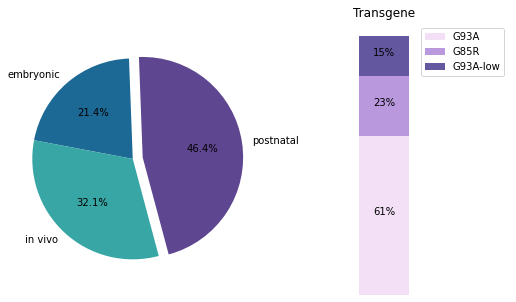

In [22]:
# make figure and assign axis objects
fig = plt.figure(figsize=(9, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(wspace=0)

colors = ['#5F4690', '#1D6996', '#38A6A5', '#0F8554', '#73AF48']
# pie chart parameters
ratios = [13, 6, 9]
labels = ['postnatal','embryonic', 'in vivo']
explode = [0.1, 0, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * ratios[0]
ax1.pie(ratios, autopct='%1.1f%%', startangle=-75,
        labels=labels, explode=explode, colors=colors)

# bar chart parameters

xpos = 0
bottom = 0
ratios = [8/13, 3/13, 2/13]
width = .2
c2 = ['#F3E0F7', '#B998DD', '#63589F']

for j in range(len(ratios)):
    height = ratios[j]
    ax2.bar(xpos, height, width, bottom=bottom, color=c2[j])
    ypos = bottom + ax2.patches[j].get_height() / 2
    bottom += height
    ax2.text(xpos, ypos, "%d%%" % (ax2.patches[j].get_height() * 100),
             ha='center')

ax2.set_title('Transgene')
ax2.legend(('G93A', 'G85R', 'G93A-low'))
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)
plt.savefig('./images/pie.pdf')

## Techonological timeline

In [23]:
text = open('text.txt', 'r').readlines()
dates = [line.split()[0] for line in text]
names = [line.strip(date).strip() for date, line in zip(dates, text)]
dates = [datetime.strptime(d, "%Y-%m") for d in dates]
levels = np.array([-2, 2, -2,  2, 4, -1,  1, -4,  4])

In [24]:
names = ['Discontinuous\n current clamp',
 'Recording from spinal\n motoneurones in\n anesthetised adult mice',
 'SOD1G93A transgenic mouse model',
 'SOD1G85R transgenic mouse model',
 'Neonatal mouse spinal cord slice',
 'Adult mouse sacral\n cord preparation',
 'Adult mouse lumbar\n cord preparation',
 'Simultaneous intracellular recording\n of a lumbar motoneuron and the\n force produced by its motor unit',
 'The preparation of oblique\n spinal cord slices for\n ventral root stimulation']

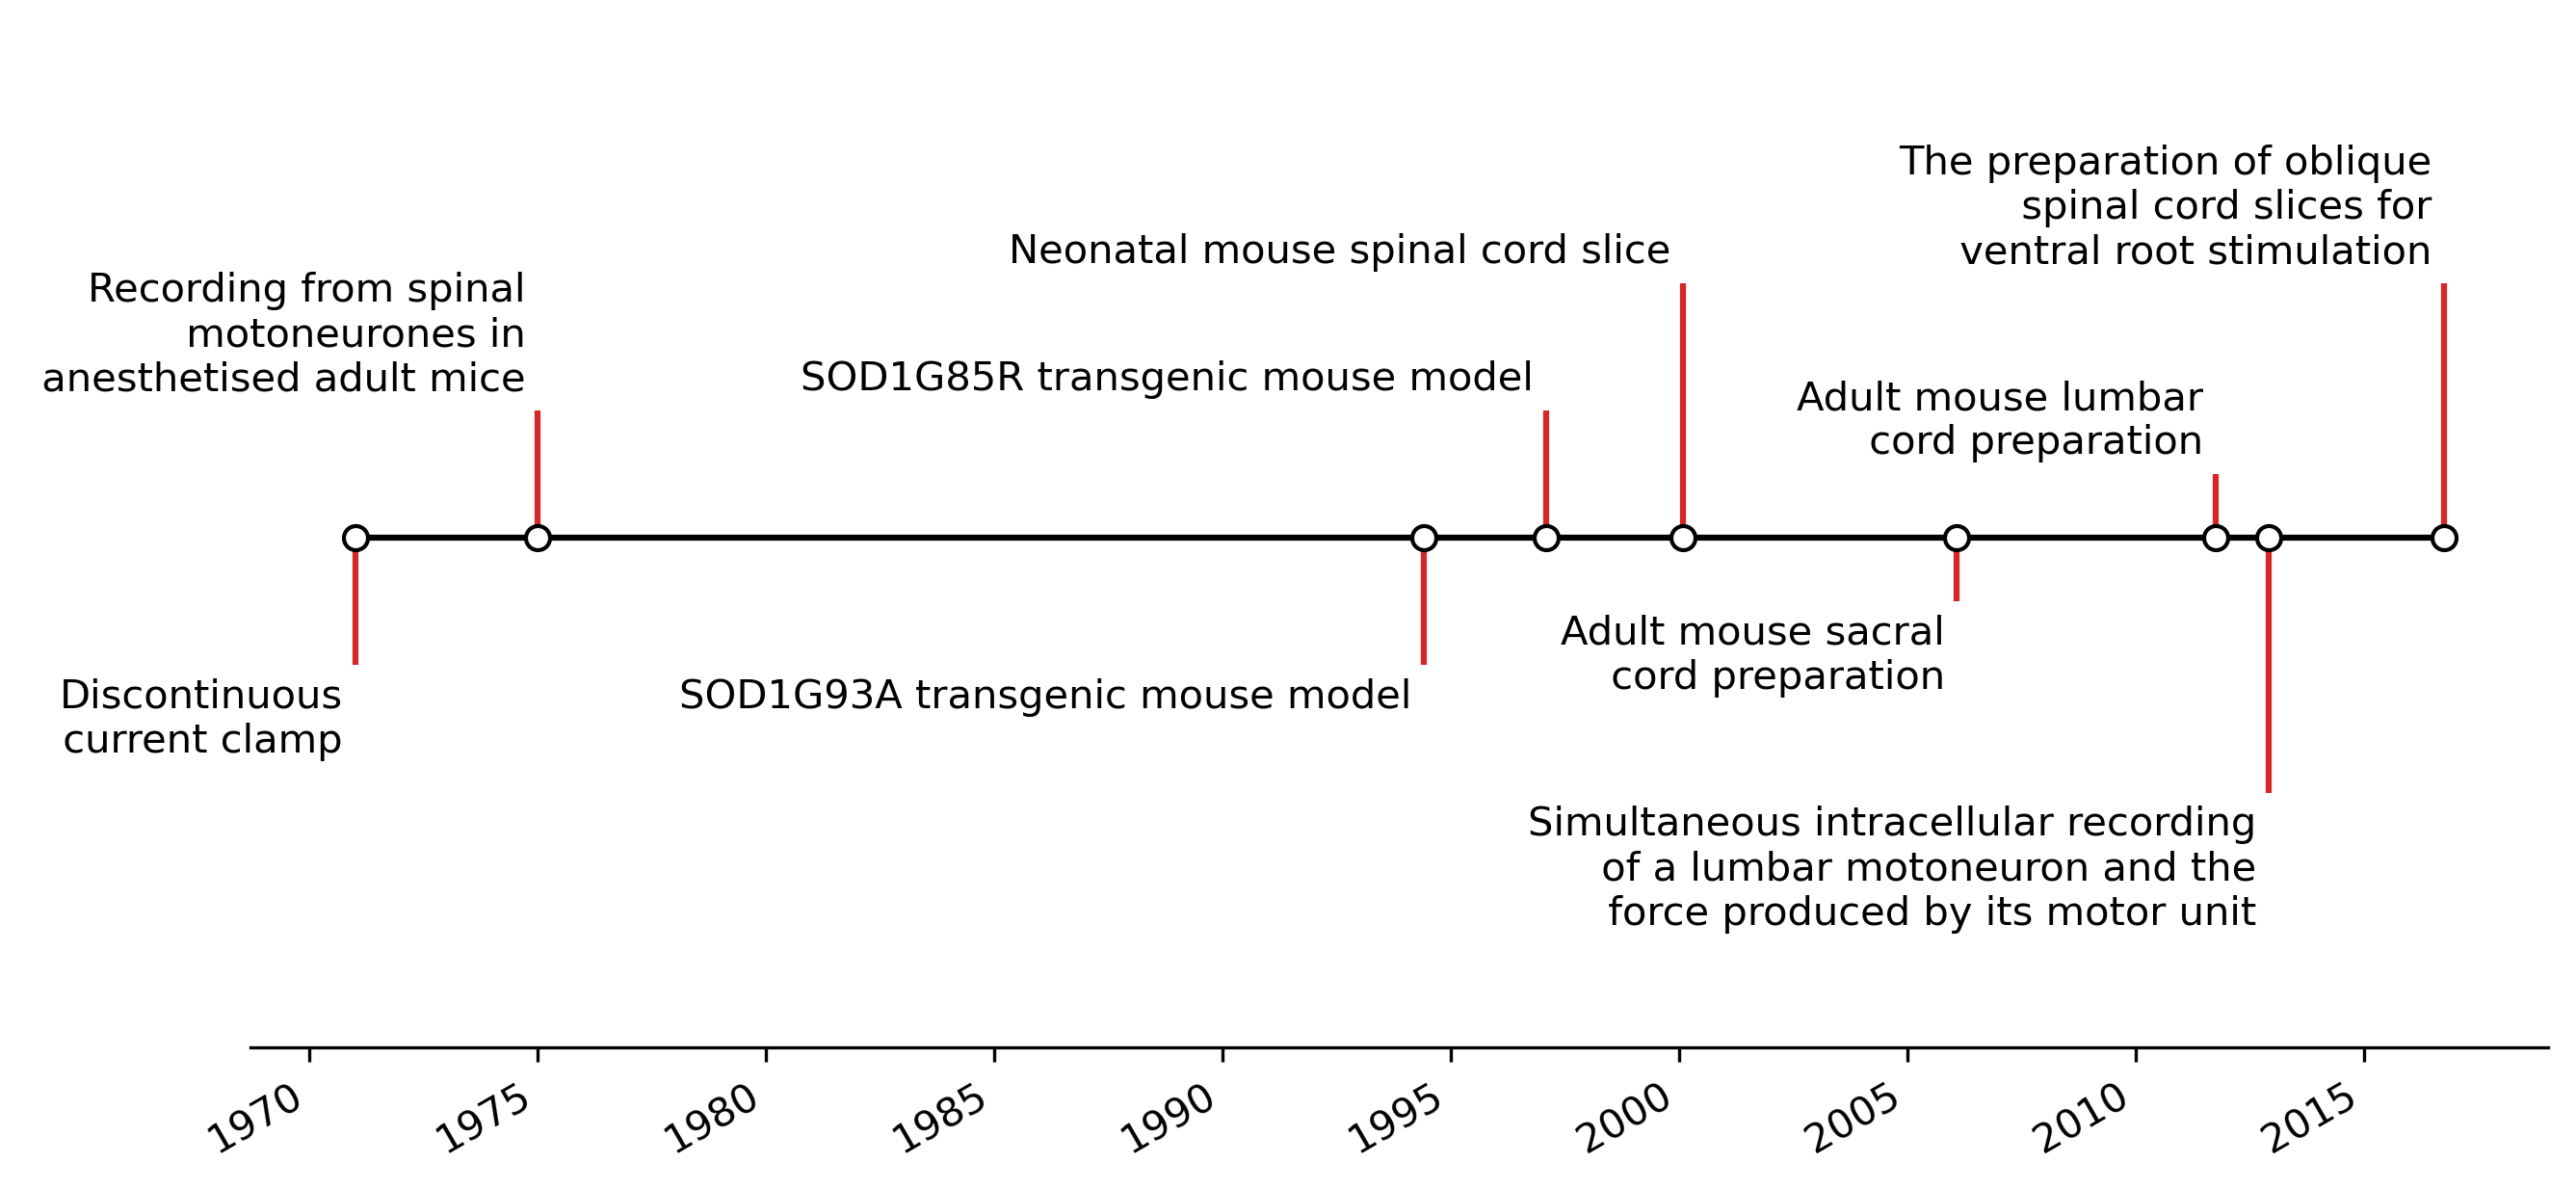

In [25]:
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True, dpi=300)
#ax.set(title="Technological timeline")

ax.vlines(dates, 0, levels, color="tab:red")  # The vertical stems.
ax.plot(dates, np.zeros_like(dates), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.

# annotate lines
for d, l, r in zip(dates, levels, names):
    ax.annotate(r, xy=(d, l),
                xytext=(-3, np.sign(l)*3), textcoords="offset points",
                horizontalalignment="right",
                verticalalignment="bottom" if l > 0 else "top")

# format xaxis with one year intervals
ax.get_xaxis().set_major_locator(mdates.YearLocator(5))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# remove y axis and spines
ax.get_yaxis().set_visible(False)
for spine in ["left", "top", "right"]:
    ax.spines[spine].set_visible(False)

ax.margins(y=0.5)
plt.savefig('./images/timeline.pdf')
plt.show()

# Overview: $I^2$ and summary effect size for each property

## Appendix A

In [26]:
df = pd.DataFrame()
for key in full['key'].unique():
    row = full.loc[full['key']==key].iloc[0]
    df = df.append(row)
df = df.loc[:, ['key', 'age', 'raw_data', 'transgene', 'type']].sort_values(by=['type', 'age'])
df['raw_data'] = df['raw_data'].map({0: 'Yes', 1: 'No'})
df

,key,age,raw_data,transgene,type
38,Kuo2005,E12–14,Yes,G93A,embryonic
104,Schuster2012,E12–14,Yes,G93A,embryonic
8,Chang2016,E13,Yes,G93A,embryonic
26,Kuo2004_embryonic,E13,Yes,G93A,embryonic
82,Pieri2003,E15,Yes,G93A,embryonic
50,Martin2013,E17.5,Yes,G93A,embryonic
0,Jensen_S,P107–116,NaN,G93A,in vivo
25,Jorgensen2020,P228,Yes,G127X,in vivo
60,Meehan2010,P242,Yes,G127X,in vivo
0,Huh_P30–60,P30–60,NaN,G93A,in vivo


## tab: full_summary

In [27]:
copy_table(metacont(full).sort_values(by='k', ascending=False))

,k,Q,Summary effect size,Confidence Interval,tau^2,I^2
RMP,27.0,30.004606,0.074039,"[-0.054, 0.2]",0.015005,0.133466
$V_{th}$,21.0,19.430527,0.061080,"[-0.085, 0.21]",0.000000,0.000000
Rheobase,19.0,48.699812,-0.286459,"[-0.55, -0.021]",0.202609,0.630389
f-I gain,18.0,45.803721,0.104187,"[-0.16, 0.37]",0.189404,0.628851
$G_{in}$,14.0,58.304095,0.015136,"[-0.36, 0.39]",0.358810,0.777031
$R_{in}$,12.0,42.037651,-0.055703,"[-0.41, 0.3]",0.278705,0.738330
$AP_{dur}$,12.0,21.943331,-0.176204,"[-0.43, 0.074]",0.094482,0.498709
$AP_{amp}$,11.0,14.348879,-0.345273,"[-0.57, -0.12]",0.041642,0.303081
$AHP_{amp}$,11.0,10.316196,0.069163,"[-0.12, 0.26]",0.003335,0.030650
$C_m$,10.0,11.675021,0.198286,"[-0.027, 0.42]",0.029589,0.229123


In [28]:
full_summary = metacont(full)

In [29]:
full_summary.index.name = 'prop'

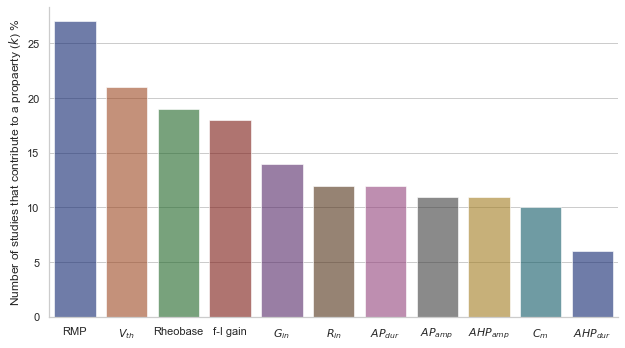

In [30]:
sns.set_theme(style="whitegrid")
g = sns.catplot( 
                y='k', 
                x=full_summary.sort_values(by='k', ascending=False).index.map(prop_labels), 
                data=full_summary.sort_values(by='k', ascending=False), 
                kind='bar', 
                aspect=12/7, 
                alpha=.6, 
                palette='dark')
g.set_axis_labels("", "Number of studies that contribute to a propaerty ($k$) %", fontsize=12)
g.savefig('./images/prop_bar.png')

## fig: full_summary

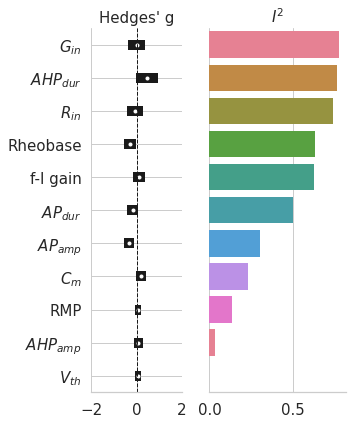

In [31]:
def draw_summary(df):
    '''Visualise the summary table generated with the metacont function'''
    df = df.sort_values(by=['I^2'], ascending=False)
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [1, 1.5]}, figsize=(5, 6))
    plt.rcParams.update(plt.rcParamsDefault)
    ax1.set_xlim(-2, 2)
    x = df['weighted mean']
    y = df['weighted mean'].index.map(prop_labels)
    ax1.plot(x, y, 'ko', markersize=3, color='w')
    x_low = df['lo']
    x_high = df['hi']
    ax1.hlines(y, x_low, x_high, lw=10, color='k')
    ax1.hlines(y,*ax1.get_xlim(), lw=0.5, color='grey', zorder=-1)
    ax1.axvline(0,ls='--',c='k', lw=1)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    for tick in ax1.get_yticklines():
        tick.set_visible(False)
    ymin,ymax = ax1.get_ylim()
    ax1.set_ylim(ymin-1, ymax+1)
    ax1.invert_yaxis()
    ax1.set_title('Hedges\' g', fontsize=15)
    ax1.tick_params(labelsize=15)
    ax2 = sns.barplot(x='I^2', 
                y=df.index.map(prop_labels), 
                data=df,
                palette=sns.color_palette("husl", 9))
    sns.despine(left=True, right=True, top=True, bottom=False)
    ax2.set(xlabel='')
    ax2.tick_params(labelsize=15)
    ax2.set_title('$I^2$', fontsize=15)
    for tick in ax2.get_yticklines():
            tick.set_visible(False)
    fig.tight_layout()
    fig.savefig('./images/full_summary.pdf')
draw_summary(metacont(full))

## Subgroups stacked

In [32]:
darker = {'AHP amp': 0, 
          'Vth': 0, 
          'capacitance': 0, 
          'RMP': 0, 
          'rheobase': 0, 
          'AP dur': 0.682263, 
          'AP amp': 0.247534,
          'Rin': 0, 
          'Gin': 0.702333, 
          'f-I gain': 0, 
          'AHP dur': 0}

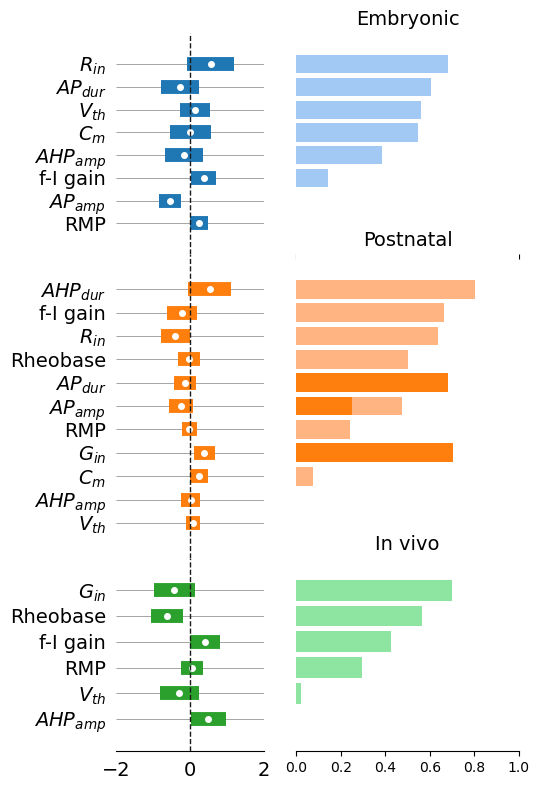

In [33]:
light = iter(sns.color_palette('pastel', 3))
default = iter(sns.color_palette('tab10', 3))

#df = df.sort_values(by=['I^2'], ascending=False)
fig, axs = plt.subplots(3, 2, 
                        gridspec_kw={
                            'width_ratios': [1, 1.5],
                            'height_ratios':[8, 11, 7]
                        }, 
                        figsize=(5.5, 8),
                        sharey='row')
plt.rcParams.update(plt.rcParamsDefault)
#plt.subplots_adjust(hspace=5)

for ax, df in zip(axs.T[0], [full.loc[full['type']==subgroup] for subgroup in ['embryonic', 'postnatal', 'in vivo']]):
    data = metacont(df).sort_values(by=['I^2'], ascending=True)
    x = data['weighted mean']
    y = data['weighted mean'].index.map(prop_labels)
    ax.plot(x, y, 'ko', markersize=4, c='w')
    x_low = data['lo']
    x_high = data['hi']
    ax.hlines(y, x_low, x_high, lw=10, color=next(default))
    ax.hlines(y,-2, 2, lw=0.5, color='grey', zorder=-1)
    ax.axvline(0,ls='--',c='k', lw=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    for tick in ax.get_yticklines():
        tick.set_visible(False)
    for tick in ax.get_xticklines():
            tick.set_visible(False)
    ymin,ymax = ax.get_ylim()
    ax.set_ylim(ymin-1, ymax+1)
    #ax.invert_yaxis()
    ax.set_xlim(-2, 2)
    ax.tick_params(labelsize=14)

for ax, df in zip(axs.T[1],
                        [full.loc[full['type']==subgroup] for subgroup in ['embryonic', 'postnatal', 'in vivo']]):
    df = metacont(df)
    df = df.sort_values(by=['I^2'], ascending=True)
    ax.barh(df.index.map(prop_labels), df['I^2'], color=next(light))
    sns.despine(left=True, right=True, top=True, bottom=False)
    ax.set_xlim(0, 1)
    for tick in ax.get_yticklines():
            tick.set_visible(False)

axs[1, 1].barh(pd.DataFrame(darker, index=range(0,11)).T[0].index.map(prop_labels), 
               pd.DataFrame(darker, index=range(0,11)).T[0].values,
              color = sns.color_palette()[1])

#axs[2, 1].barh(metacont(in_vivo.loc[in_vivo['transgene']=='G93A'])['I^2'].index.map(prop_labels), 
              #metacont(in_vivo.loc[in_vivo['transgene']=='G93A'])['I^2'].values, color = sns.color_palette()[2],
              #alpha=0.3)
               
for ax in axs[0:2].flat:
    ax.tick_params(labelbottom=False)
    ax.spines['bottom'].set_visible(False)
for tick in ax.get_xticklines():
    tick.set_visible(False)
for ax, title in zip(axs.T[1], ['Embryonic', 'Postnatal', 'In vivo']):
    ax.set_title(title, fontsize=14)

fig.tight_layout()
plt.subplots_adjust(hspace=0)
fig.savefig('./images/stacked.pdf')

# Individual effect sizes for each property in each experiment

## Embryonic experiments

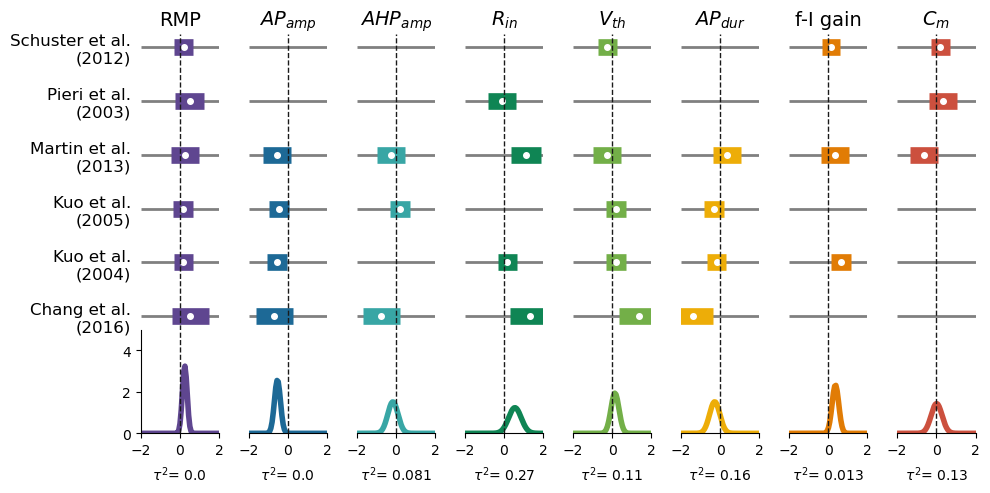

In [34]:
effects = embryonic.pivot_table(index=['prop', 'key'], values=['g', 'hi', 'lo'], dropna=False)
props = ['RMP', 'AP amp', 'AHP amp', 'Rin', 'Vth', 'AP dur', 'f-I gain',
       'capacitance']
study_labels = {'Kuo2004_embryonic': 'Kuo et al.\n(2004)',
                'Pieri2003': 'Pieri et al.\n(2003)',
                'Kuo2005': 'Kuo et al.\n(2005)', 
                'Schuster2012': 'Schuster et al.\n(2012)', 
                'Martin2013': 'Martin et al.\n(2013)',
                'Chang2016': 'Chang et al.\n(2016)'}
overall = metacont(embryonic)

#No gridspec this time
fig, axes = plt.subplots(2, 8, sharey='row',
                         gridspec_kw={'height_ratios': [2, 0.7]}, 
                         figsize=(10, 5)
                        )

#Drawing the forest plots
cycler = cycle(qualitative.Prism_8.hex_colors)

for prop, ax in zip(props, axes[0]):
    ax.set_xlim(-2,2)
    c = next(cycler)
    x = effects.loc[prop]['g']
    y = effects.loc[prop]['g'].index.map(study_labels)
    ax.plot(
        x,
        y, 
        'ko', 
        markersize=4, 
        c='w',
    )
    ax.set_title(prop_labels[prop], fontsize=14)
    x_low = effects.loc[prop]['lo']
    x_high = effects.loc[prop]['hi']
    ymin,ymax = ax.get_ylim()
    ax.set_ylim(ymin-1, ymax+1)
    ax.hlines(y, x_low, x_high, lw=12, color=c)
    ax.hlines(y,*ax.get_xlim(), lw=2, color='grey', zorder=-1)
    ax.axvline(0,ls='--',c='k', lw=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    for tick in ax.get_yticklines():
        tick.set_visible(False)
    for tick in ax.get_xticklines():
        tick.set_visible(False)
    ymin,ymax = ax.get_ylim()
    ax.set_ylim(ymin-1, ymax+1)
    ax.invert_yaxis()
    #ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.tick_params(labelbottom=False, axis='both',labelsize=12)

    # The overall effect shown as curves    
for prop, ax in zip(props, axes[1]):
    ax.set_xlim(-2,2)
    #spline
    x = np.linspace(-2, 2, 100)
    y = norm.pdf(np.linspace(-2, 2, 100), 
                 overall.loc[prop, 'weighted mean'], 
                 sqrt(overall.loc[prop, 'variance']))
    tck = interpolate.splrep(x, y, s=0)
    xnew = np.arange(-2, 2*np.pi, np.pi/50)
    ynew = interpolate.splev(xnew, tck, der=0)
    ax.plot(xnew,ynew, c=next(cycler), lw=4)
    #ax.hlines(y,*ax.get_xlim(), lw=0.5, color='grey', zorder=-1)
    ax.axvline(0,ls='--',c='k', lw=1)
    ymin,ymax = ax.get_ylim()
    ax.set_ylim(ymin-1, ymax+1)
    #sns.despine(left=True, right=True, top=True, bottom=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0,5)
    #ax.fill_between(x, y, 0, color=next(cycler), alpha=0.8)
    ax.text(0.5, -0.3, 
            '$τ^2$= ' + str('{:.2}'.format(overall.loc[prop,'tau^2'])), 
            horizontalalignment='center', 
            verticalalignment='top', 
            transform=ax.transAxes)
for ax in axes[1, 1:9]:
    ax.spines['left'].set_visible(False)
    for tick in ax.get_yticklines():
        tick.set_visible(False)
fig.tight_layout()
plt.subplots_adjust(hspace = .001)
fig.savefig('./images/embryonic2.pdf')

## Postnatal experiments

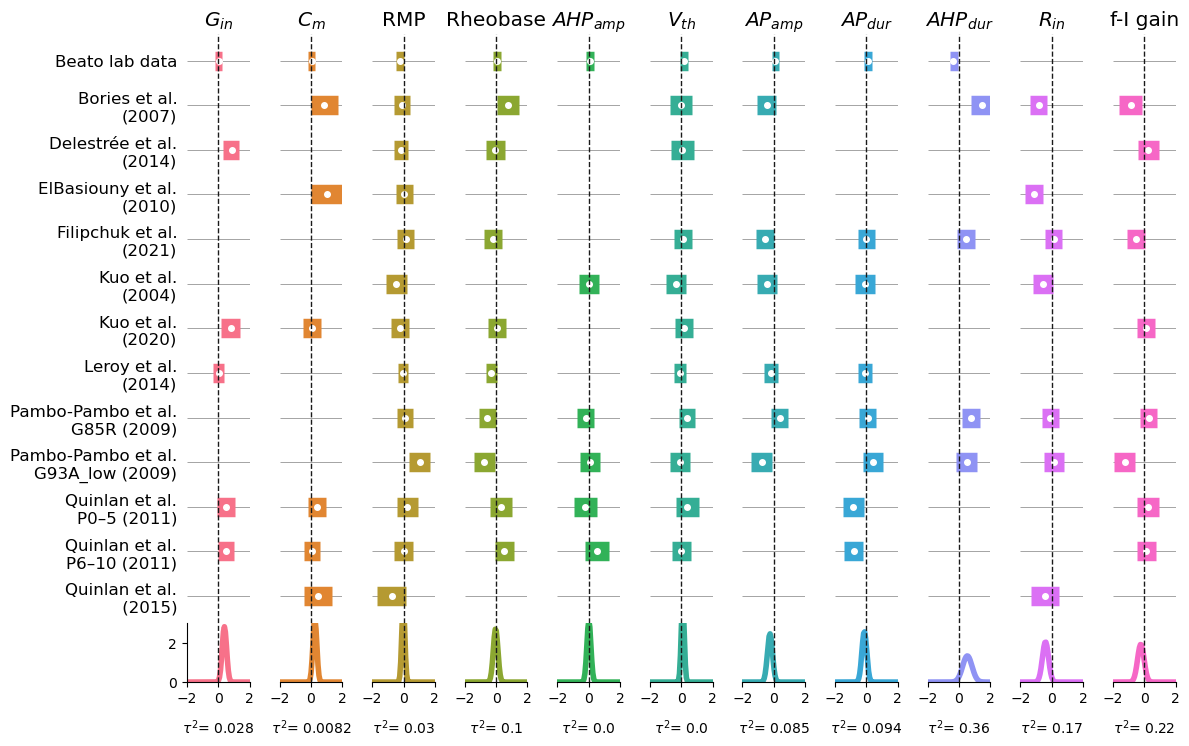

In [35]:
effects = postnatal.pivot_table(index=['prop', 'key'], values=['g', 'hi', 'lo'], dropna=False)
props = ['Gin', 'capacitance', 'RMP', 'rheobase', 'AHP amp', 'Vth',
       'AP amp', 'AP dur', 'AHP dur', 'Rin', 'f-I gain']
study_labels = {'Beato': 'Beato lab data', 
                'Bories2007': 'Bories et al.\n(2007)', 
                'Delestree2014': 'Delestrée et al.\n(2014)', 
                'ElBasiouny2010': 'ElBasiouny et al.\n(2010)',
                'Filipchuk2021': 'Filipchuk et al.\n(2021)',
                'Kuo2004_post': 'Kuo et al.\n(2004)', 
                'Kuo2020': 'Kuo et al.\n(2020)', 
                'Leroy2014': 'Leroy et al.\n(2014)',
                'Pambo-Pambo_G85R': 'Pambo-Pambo et al.\nG85R (2009)', 
                'Pambo-Pambo_G93A-low': 'Pambo-Pambo et al.\nG93A_low (2009)', 
                'Quinlan2011_P0–5': 'Quinlan et al.\nP0–5 (2011)',
                'Quinlan2011_P6–10': 'Quinlan et al.\nP6–10 (2011)', 
                'Quinlan2015': 'Quinlan et al.\n (2015)'}
overall = metacont(postnatal)

cycler = cycle(list(sns.color_palette("husl", 11)))
fig, axes = plt.subplots(2, 11, sharey='row',
                         gridspec_kw={'height_ratios': [3, 0.3]}, 
                         figsize=(12, 7.5)
                        )
for prop, ax in zip(props, axes[0]):
    ax.set_xlim(-2,2)
    c = next(cycler)
    x = effects.loc[prop]['g']
    y = effects.loc[prop]['g'].index.map(study_labels)
    ax.plot(
        x,
        y, 
        'ko', 
        markersize=4, 
        c='w'
    )
    ax.set_title(prop_labels[prop], fontsize=14.5)
    x_low = effects.loc[prop]['lo']
    x_high = effects.loc[prop]['hi']
    ax.axvline(0,ls='--',c='k', lw=1)
    ax.hlines(y, x_low, x_high, lw=14, color=c)
    ax.hlines(y,*ax.get_xlim(), lw=0.5, color='grey', zorder=-1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    for tick in ax.get_yticklines():
        tick.set_visible(False)
    for tick in ax.get_xticklines():
        tick.set_visible(False)
    ymin,ymax = ax.get_ylim()
    #ax.set_ylim(ymin-1, ymax+1)
    ax.invert_yaxis()
    #ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.tick_params(labelbottom=False, axis='both',labelsize=12)

    # The overall effect shown as curves    
for prop, ax in zip(props, axes[1]):
    ax.set_xlim(-2,2)
    #spline
    x = np.linspace(-2, 2, 100)
    y = norm.pdf(np.linspace(-2, 2, 100), 
                 overall.loc[prop, 'weighted mean'], 
                 sqrt(overall.loc[prop, 'variance']))
    tck = interpolate.splrep(x, y, s=0)
    xnew = np.arange(-2, 2*np.pi, np.pi/50)
    ynew = interpolate.splev(xnew, tck, der=0)
    ax.plot(xnew,ynew, c=next(cycler), lw=4)
    #ax.hlines(y,*ax.get_xlim(), lw=0.5, color='grey', zorder=-1)
    ax.axvline(0,ls='--',c='k', lw=1)
    #sns.despine(left=True, right=True, top=True, bottom=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0,3)
    #ax.fill_between(x, y, 0, color=next(cycler))
    ax.text(0.5, -0.6, 
            '$τ^2$= ' + str('{:.2}'.format(overall.loc[prop,'tau^2'])), 
            horizontalalignment='center', 
            verticalalignment='top', 
            transform=ax.transAxes)
for ax in axes[1, 1:11]:
    ax.spines['left'].set_visible(False)
    for tick in ax.get_yticklines():
        tick.set_visible(False)
fig.tight_layout()
plt.subplots_adjust(hspace = .001)
fig.savefig('./images/postnatal2.pdf')

## *In vivo* experiments

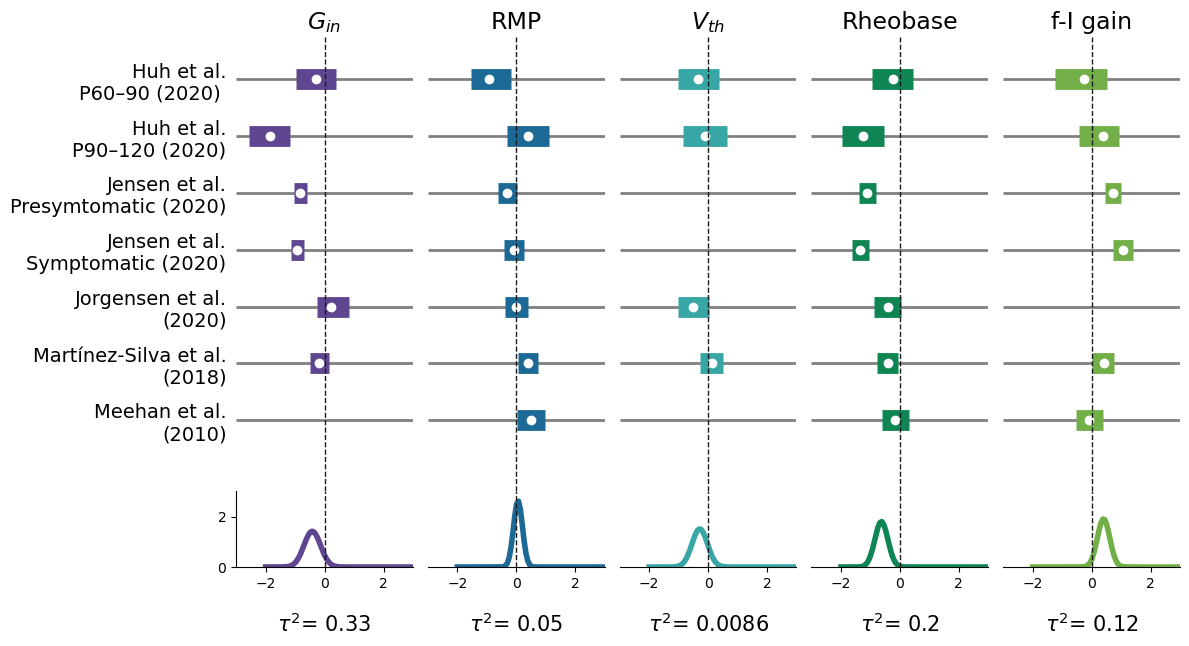

In [36]:
effects = in_vivo.pivot_table(index=['prop', 'key'], values=['g', 'hi', 'lo', 'var'], dropna=False)
props = ['Gin', 'RMP', 'Vth', 'rheobase', 'f-I gain']
study_labels = {'MartinezSilva2018': 'Martínez-Silva et al.\n(2018)', 
                'Huh_P60–90': 'Huh et al.\nP60–90 (2020) ', 
                'Huh_P30–60': 'Huh et al.\nP30–60 (2020) ',
                'Huh_P90–120': 'Huh et al.\nP90–120 (2020)',
                'Jensen_S': 'Jensen et al.\nSymptomatic (2020)', 
                'Jensen_PS': 'Jensen et al.\nPresymtomatic (2020)', 
                'Baczyk2020': 'Baczyk et al.\n(2020)', 
                'Meehan2010': 'Meehan et al.\n(2010)',
                'Jorgensen2020': 'Jorgensen et al.\n(2020)'}
overall = metacont(in_vivo)

cycler = cycle(qualitative.Prism_5.hex_colors)
fig, axes = plt.subplots(2, 5, sharey='row',
                         gridspec_kw={'height_ratios': [3, 0.5]}, 
                         figsize=(12, 6.5)
                        )
for prop, ax in zip(props, axes[0]):
    ax.set_xlim(-3,3)
    c = next(cycler)
    df = effects.loc[prop]
    x = df['g']
    y = df['g'].index.map(study_labels)
    ax.plot(
        x,
        y, 
        'ko', 
        markersize=6, 
        c='w'
    )
    ax.set_title(prop_labels[prop], fontsize=17)
    x_low = df['lo']
    x_high = df['hi']
    ax.hlines(y, x_low, x_high, lw=15, color=c)
    ax.hlines(y,*ax.get_xlim(), lw=2, color='grey', zorder=-1)
    ax.axvline(0,ls='--',c='k', lw=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    for tick in ax.get_yticklines():
        tick.set_visible(False)
    for tick in ax.get_xticklines():
        tick.set_visible(False)
    ymin,ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax+0.3)
    ax.invert_yaxis()
    #ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.tick_params(
        labelbottom=False, 
        axis='both',
        labelsize=14)

    # The overall effect shown as curves    
for prop, ax in zip(props, axes[1]):
    ax.set_xlim(-3,3)
    #spline
    x = np.linspace(-2, 2, 100)
    y = norm.pdf(np.linspace(-2, 2, 100), 
                 overall.loc[prop, 'weighted mean'], 
                 sqrt(overall.loc[prop, 'variance']))
    tck = interpolate.splrep(x, y, s=0)
    xnew = np.arange(-2, 2*np.pi, np.pi/50)
    ynew = interpolate.splev(xnew, tck, der=0)
    ax.plot(xnew,ynew, c=next(cycler), lw=4)
    #ax.hlines(y,*ax.get_xlim(), lw=0.5, color='grey', zorder=-1)
    ax.axvline(0,ls='--',c='k', lw=1)
    #sns.despine(left=True, right=True, top=True, bottom=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0,3)
    #ax.fill_between(x, y, 0, color=next(cycler))
    ax.text(0.5, -0.6, 
            '$τ^2$= ' + str('{:.2}'.format(overall.loc[prop,'tau^2'])), 
            horizontalalignment='center', 
            verticalalignment='top', 
            transform=ax.transAxes,
           fontsize=15)
for ax in axes[1, 1:11]:
    ax.spines['left'].set_visible(False)
    for tick in ax.get_yticklines():
        tick.set_visible(False)
fig.tight_layout()
plt.subplots_adjust(hspace = .001)
fig.savefig('./images/in_vivo2.pdf')

# Power and Precision

In [37]:
analysis = TTestIndPower()

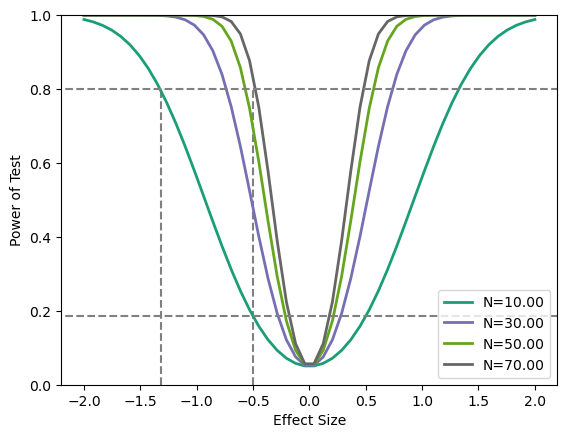

In [38]:
fig=analysis.plot_power(dep_var='effect_size', 
                    effect_size=np.linspace(-2, 2, 50), 
                    nobs=np.array([10, 30, 50, 70]))
ax = fig.axes[0]
ax.set_ylabel('Power of Test')
ax.set_title('')
ax.axhline(0.8, ax.get_xlim()[0], ax.get_xlim()[1], c='grey', ls='--')
ax.axhline(0.185, ax.get_xlim()[0], ax.get_xlim()[1], c='grey', ls='--')
ax.vlines(-0.5, ymin=0, ymax=0.8,color='grey', ls='--')
ax.vlines(-1.32, ymin=0, ymax=0.8,color='grey', ls='--')
ax.set_ylim(0, 1)
fig.savefig('./images/power.pdf')

# Timecourse figure

## Version 1

In [39]:
width_ratio = [5, 5, 6, 10, 15, 15, 15]

In [40]:
props = ['Gin', 'RMP', 'f-I gain', 'rheobase']
age_group = ['embryonic', 'P0–5', 'P6–12', 'P15–25', 'P30–60', 'P60–90', 'P90–120']

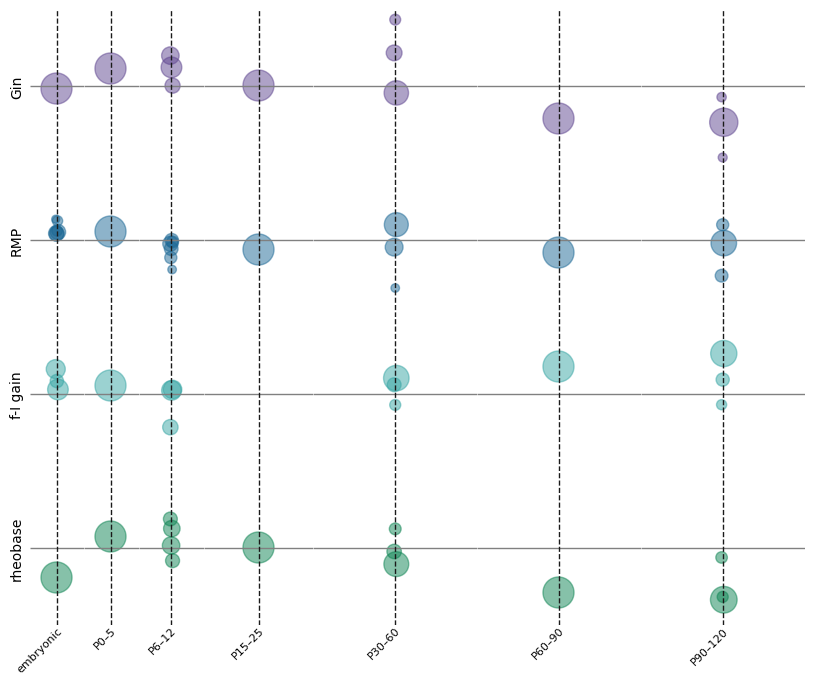

In [41]:
fig, axs = plt.subplots(4, 7, gridspec_kw={'width_ratios': width_ratio},
                       sharey='row', 
                        sharex='col', 
                       figsize=(10, 8))
fig.subplots_adjust(wspace=0, hspace=0)
c = {'Gin': Prism_4.hex_colors[0],
    'RMP': Prism_4.hex_colors[1],
    'f-I gain': Prism_4.hex_colors[2],
    'rheobase': Prism_4.hex_colors[3]}

for row, prop in zip(axs, props):
    for ax, age, width in zip(row, age_group, width_ratio):
        ax.set_xlim(0, width)
        ax.set_ylim(-2, 2)
        df = full.loc[(full['age_group']==age)&(full['prop']==prop)]
        x_temp = np.linspace(-0.1,0.1,len(df))
        midline = ax.get_xlim()[1]/2
        ax.axvline(midline, ls='--',c='k', lw=1)
        ax.scatter(midline+x_temp, df['g'], 
                   s=500*((1/df['var'].values)/sum(1/df['var'].values)), 
                   alpha=0.5,
                   c=c[prop])
        ax.tick_params(labelleft=False, labelbottom=False)
        ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], lw=1, color='grey')
        for tick in ax.get_yticklines():
            tick.set_visible(False)
        for tick in ax.get_xticklines():
            tick.set_visible(False)
        sns.despine(ax=ax,left=True, right=True, top=True, bottom=True)
for ax, prop in zip(axs.T[0], props):
    ax.set_ylabel(prop)
    #for tick in ax.get_yticklines():
            #tick.set_visible(True)
    #ax.tick_params(labelleft=True)
    #ax.spines['left'].set_visible(True)
for ax, label in zip(axs[3], ['embryonic', 'P0–5', 'P6–12', 'P15–25', 'P30–60', 'P60–90', 'P90–120']):
    x = ax.get_xlim()[1]/2
    ax.annotate(label, xy=(x, 0), xycoords=('data','axes fraction'), 
        xytext=(0,0), 
        textcoords='offset points', 
        rotation=45, 
        ha="right", 
        va='top', 
        rotation_mode="anchor", 
        fontsize=8)
fig.savefig('./images/timecourse.pdf')

## Version 2

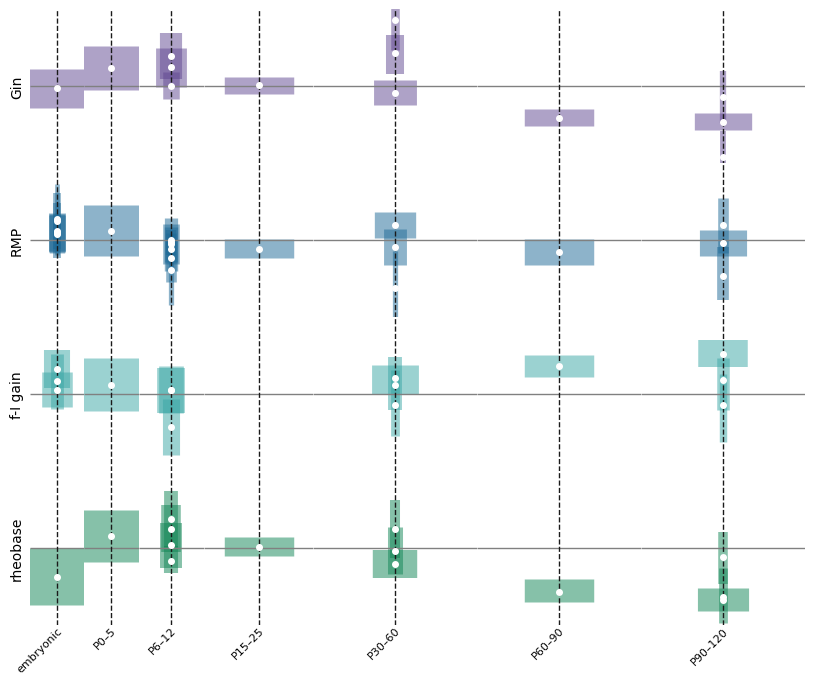

In [42]:
fig, axs = plt.subplots(4, 7, gridspec_kw={'width_ratios': width_ratio},
                       sharey='row', 
                        sharex='col', 
                       figsize=(10, 8))
fig.subplots_adjust(wspace=0, hspace=0)
c = {'Gin': qualitative.Prism_4.hex_colors[0],
    'RMP': qualitative.Prism_4.hex_colors[1],
    'f-I gain': qualitative.Prism_4.hex_colors[2],
    'rheobase': qualitative.Prism_4.hex_colors[3]}

for row, prop in zip(axs, props):
    for ax, age, width in zip(row, age_group, width_ratio):
        ax.set_xlim(0, width)
        ax.set_ylim(-2, 2)
        df = full.loc[(full['age_group']==age)&(full['prop']==prop)]
        x_temp = np.linspace(-0.001,0.001,len(df))
        midline = ax.get_xlim()[1]/2
        ax.axvline(midline, ls='--',c='k', lw=1)
        ax.plot(midline+x_temp, 
                df['g'],
                'o',
                #alpha=0.5,
                c='w',
               markersize=4)
        ax.vlines(midline+x_temp, 
                  ymin=df['lo'],
                 ymax=df['hi'],
                 color=c[prop], alpha=0.5, lw=50*(1/df['var'].values)/sum(1/df['var'].values))
        ax.tick_params(labelleft=False, labelbottom=False)
        ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], lw=1, color='grey')
        for tick in ax.get_yticklines():
            tick.set_visible(False)
        for tick in ax.get_xticklines():
            tick.set_visible(False)
        sns.despine(ax=ax,left=True, right=True, top=True, bottom=True)
for ax, prop in zip(axs.T[0], props):
    ax.set_ylabel(prop)
    #for tick in ax.get_yticklines():
            #tick.set_visible(True)
    #ax.tick_params(labelleft=True)
    #ax.spines['left'].set_visible(True)
for ax, label in zip(axs[3], ['embryonic', 'P0–5', 'P6–12', 'P15–25', 'P30–60', 'P60–90', 'P90–120']):
    x = ax.get_xlim()[1]/2
    ax.annotate(label, xy=(x, 0), xycoords=('data','axes fraction'), 
        xytext=(0,0), 
        textcoords='offset points', 
        rotation=45, 
        ha="right", 
        va='top', 
        rotation_mode="anchor", 
        fontsize=8)
fig.savefig('./images/timecourse2.pdf')

# Repetitive firing *in vivo*

In [43]:
firing = pd.read_excel('./firing.xlsx')

In [44]:
firing = firing.reindex([0, 1, 3, 2, 4, 5, 6])

In [45]:
data = firing.melt(id_vars=['key'], value_vars=['WT', 'mutant', 'S']).dropna()
data = data.rename(columns={'variable': 'genotype'})
data.iloc[[14, 15], 1] = 'Symptomatic'

In [46]:
tick_label = ['Jensen et al.\nSOD1G93A\n3kHz', 'Jensen et al.\nSOD1G93A\n8kHz', 'Jorgensen et al.\nSOD127X', 'Huh et al.\nSOD1G93A', 'Martinez-Silva et al.\nSOD1G93A',
'Martinez-Silva et al.\nFUSP525L', 'Delestree et al.\nSOD1G93A' 
]

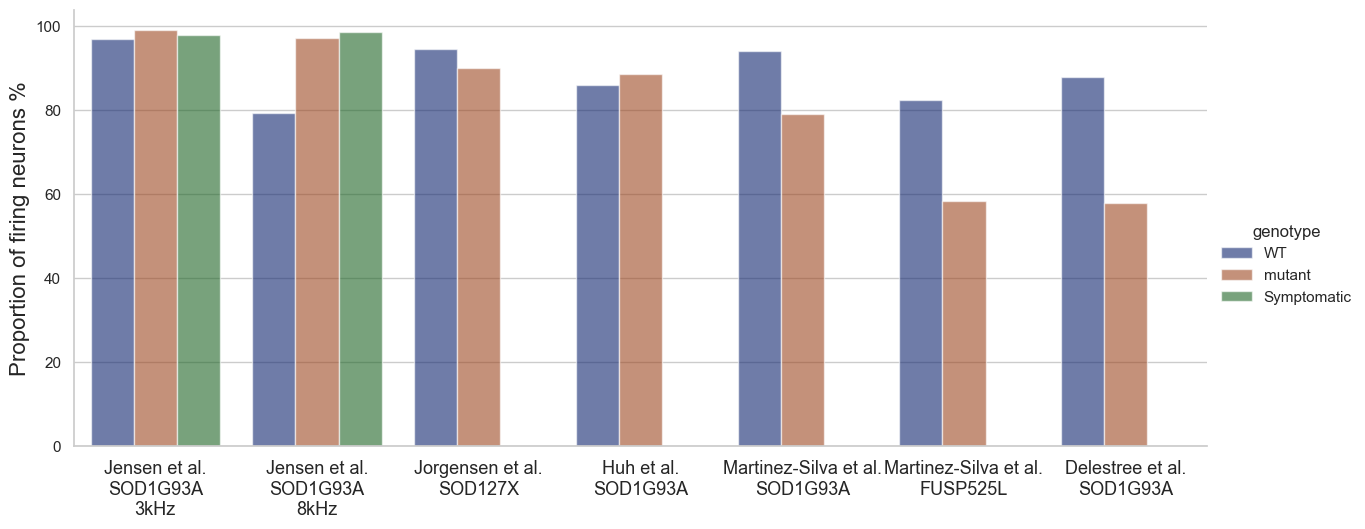

In [47]:
sns.set_theme(style="whitegrid")
g = sns.catplot(hue='genotype', y='value', x='key', data=data, kind='bar', aspect=20/8.27, alpha=.6, palette='dark')
g.set_axis_labels("", "Proportion of firing neurons %", fontsize=16).set_xticklabels(tick_label, fontsize=13)
g.savefig('./images/firing.pdf')